# Running the nonadiabatic molecular dynamics (NA-MD)

In this tutorial, we perform NA-MD using the NACs computed in [step3](../../8_step3_cp2k/2_xTB). After the dynamic is done, we will fit the data using a stretched-compressed exponential function. We only do the dynamics for the NACs computed for the system in the xTB framework. The reason is that doing the NA-MD for the other system we considered with DFT, the rutile-$TiO_2$ unit cell, is exactly the same as below and you just need to modify some parameters as is explained in the [README.md](README.md) file. 

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
2. [Overview of required files](#required_files)
3. [Defining the functions and variables](#def_fun_var)
4. [Run the dynamics](#run_dyn) 
5. [Decoherence times](#deco_times)
6. [Fitting data](#fit_data)

### A. Learning objectives

* To be able to run the NA-MD using Libra
* To be able to compute the decoherence times
* To be able to compute the average NA-MD timescales

### B. Use cases

* [Run the dynamics](#run_dyn)
* [Decoherence times](#deco_times)
* [Fitting data](#fit_data)


### C. Functions

- `libra_py`
  - `data_conv`
  - `data_stat`
  - `data_outs`
  - `data_read`
  - `workflows`
    - `nbra`
      - [`step4`](#run_dyn)
        - [`namd_workflow`](#run_dyn)
      - [`decoherence_times`](#deco_times)
        - [`decoherence_times`](#deco_times)
  - `units`
    - `fs2au`
    


## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

Since the data are stored in sparse format using `scipy.sparse` library, we need to load this library to read them. Import `numpy`, `scipy.sparse`, `data_conv`, `data_outs`, `data_stat`, `data_io`, `units`, and `step4` modules and also the `ann` for doing the NA-MD using artificial neural netwrok (we do not cover this in here). Also, `multiprocessing` library will be needed to simultaneously run the NA-MD in different batches.
The `scipy.optimize.curve_fit` will be used to fit the data and plot them using `matplotlib`.

In [15]:
import os
import sys
import math
import time
import glob 

import multiprocessing as mp
import numpy as np
import scipy.sparse as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline

from liblibra_core import *
import util.libutil as comn
from libra_py import units as units
from libra_py import data_conv, data_stat, data_outs, data_read
import libra_py.workflows.nbra.decoherence_times as decoherence_times
import libra_py.workflows.nbra.step4 as step4
import libra_py.workflows.nbra.ann as ann

## 2. Overview of required files <a name="required_files"></a>
[Back to TOC](#toc)

The only files that we need are the NACs obtained in [this tutorial](../../8_step3_cp2k/2_xTB/res-mixed-basis).

The `inputs.tar.bz2` archive is the `data.tar.bz2` archive from that tutorial. 

We only need to unpack it:

    tar -xjf inputs.tar.bz2

## 3. Defining the functions and variables <a name="def_fun_var"></a>
[Back to TOC](#toc)

The helper functions are used in here. We will set the parameters in here. The list of all parameters are completely explained in the [README.md](README.md) file.

In [21]:
class tmp:
    pass


#obj = tmp()
#obj.basis_transform = CMATRIX(2,2)
#obj.basis_transform.identity()


def compute_model_nbra_direct_global(q, params, full_id):
    """   
    Read in the vibronic Hamiltonians along the trajectories    

    Args: 
        q ( MATRIX(1,1) ): coordinates of the particle, ndof, but they do not really affect anything
        params ( dictionary ): model parameters

            * **params["timestep"]** ( int ):  [ index of the file to read ]
            * **params["prefix"]**   ( string ):  [ the directory where the hdf5 file is located ]
            * **params["filename"]** ( string ):  [ the name of the HDF5 file ]
        
    Returns:       
        PyObject: obj, with the members:

            * obj.hvib_adi ( CMATRIX(n,n) ): adiabatic vibronic Hamiltonian 
            
    """

    timestep = params["timestep"]
    nadi = params["nstates"]

    #=========== Basis transform, if available =====
    basis_transform = CMATRIX(nadi, nadi)
    basis_transform.identity()

    #========= Time-overlap matrices ===================
    time_overlap_adi = CMATRIX(nadi, nadi)
    time_overlap_adi.identity()

    obj = tmp()
    obj.ham_adi = params["HADI"][timestep]
    obj.nac_adi = params["NAC"][timestep]
    obj.hvib_adi = params["HVIB"][timestep]
    obj.basis_transform = basis_transform
    obj.time_overlap_adi = params["ST"][timestep]

    return obj

def get_avegage_energies(Hvib):
        
    nsteps = len(Hvib[0])
    nstates   = Hvib[0][0].num_of_cols

    # Make a list for the SD energies and populate it
    dE = [0.0]*nstates
        
    for step in range( nsteps ):
        for i in range( nstates ):
            dE[i] += Hvib[0][step].get( i, i ).real - Hvib[0][step].get( 0, 0 ).real 
            
    for i in range( nstates ):
        dE[i] = dE[i] / nsteps
        
    return dE


def compute_model(q, params, full_id):
    model = params["model"]
    res = None

    if model==1:
        pass
    elif model==2:
        #res = ham.compute_model_nbra_2state_direct(q, params, full_id)        
        res = compute_model_nbra_direct_global(q, params, full_id)
    elif model==3:
        res = ann.compute_model_nbra_ann(q, params, full_id)
        #res.time_overlap_adi = ST[ params["timestep"] ]

    return res



#if __name__ == '__main__':

def run_dynamics(case, what):



    if case=="direct" and what in [0, 2] :
        os.system("mkdir namd_regular")
    elif case=="ann" and what in [0, 2]:
        os.system("mkdir namd_ann")


    nthreads = 8
    methods = {0:"FSSH", 1:"IDA", 2:"mSDM", 3:"DISH", 21:"mSDM2", 31:"DISH2" }
    init_states = [10]
    tsh_methods = [2,21]#, 1]
    batches = list(range(4))





    #================== SET UP THE DYNAMICS AND DISTRIBUTED COMPUTING SCHEME  ===============                      

    rnd = Random()

    #rates = None
    #gaps = None
    istep = 1200
    fstep = 1997
    path_to_npz_files = os.getcwd()+'/res-mb-sd-DFT'
    HVIB_CI = []
    HAM_CI = []
    NAC_CI = []
    ST_CI = []
    # Loop over all the step starting from geometry icond
    for i in range(istep,fstep):
        print('Reading data of step',i)
        hvib_re = np.array(sp.load_npz(F'{path_to_npz_files}/Hvib_sd_{i}_re.npz').todense().real)
        hvib_re_MATRIX = data_conv.nparray2MATRIX(hvib_re)
        hvib_im1 = np.array(sp.load_npz(F'{path_to_npz_files}/Hvib_sd_{i}_im.npz').todense().real)
        hvib_im = np.zeros(hvib_im1.shape)
    #    for iii in range(hvib_im1.shape[0]):
    #        try:
    #            hvib_im[iii,iii]    = hvib_im1[iii,iii]
    #            hvib_im[iii,iii+1]  = hvib_im1[iii,iii+1]
    #            hvib_im[iii+1,iii]  = hvib_im1[iii+1,iii]
    #        except:
    #            pass
        hvib_im1[0,:] *= np.sqrt(2)
        hvib_im1[:,0] *= np.sqrt(2)
        hvib_im_MATRIX = data_conv.nparray2MATRIX(hvib_im1)
        HVIB_CI.append( CMATRIX(hvib_re_MATRIX, hvib_im_MATRIX) )
        St_re = np.array(sp.load_npz(F'{path_to_npz_files}/St_sd_{i}_re.npz').todense().real)
        St_re_MATRIX = data_conv.nparray2MATRIX(St_re)
        if i==istep:
            zero = MATRIX(hvib_re.shape[0], hvib_re.shape[1])
        HAM_CI.append( CMATRIX(hvib_re_MATRIX, zero) )
        NAC_CI.append( CMATRIX(zero, -1.0 * hvib_im_MATRIX) )
        ST_CI.append( CMATRIX(St_re_MATRIX, zero) )    
    
    
    
 #================== COMPUTE DEPHASING AND ENERGY GAPS  ===============
    
    
    dE = get_avegage_energies([HVIB_CI])
    
    print("Average energies above the GS are")
    for indx, de in enumerate(dE):
        print(F"State {indx} energy {de * units.au2ev} eV")
    
    
    nst = len(dE)
    gaps = MATRIX(nst, nst)
    for istate1 in range(nst):
        for istate2 in range(nst):        
            gaps.set(istate1, istate2,  math.fabs(dE[istate1] - dE[istate2]) )    
    

    params_common = { "path_to_res_files": os.getcwd()+'/res-mb-sd-DFT', "is_sparse": True,
                      "Hvib_re_prefix": 'Hvib_ci_', "Hvib_re_suffix": '_re',
                      "Hvib_im_prefix": 'Hvib_ci_', "Hvib_im_suffix": '_im', "istep": 1200,
                      "St_re_prefix": 'St_ci_', "St_re_suffix": '_re',
                      "nsteps": 797, "dt":1*units.fs2au, "is_parallel": True,
                      "ntraj":100, "x0":[-4.0], "p0":[4.0], "masses":[2000.0], "k":[0.01],
                      "nstates":10, "istate":[1, 0],
                      "which_adi_states":range(10), "which_dia_states":range(10),
                      "rep_ham":1, "tsh_method":0, "force_method":0, "nac_update_method":0,
                      "hop_acceptance_algo":31, "momenta_rescaling_algo":0,
                      "time_overlap_method":1, "mem_output_level":-1,  "txt_output_level":-1, "txt2_output_level":3,
                      "properties_to_save": ['timestep', 'time', 'SH_pop', 'SH_pop_raw'],
                      "state_tracking_algo":0, "convergence":0,  "max_number_attempts":100,
                      "do_phase_correction":0, "ave_gaps":gaps,
                      "min_probability_reordering":0.01, "decoherence_algo":0, "Temperature": 300.0,
                      "isNBRA":0
                    }


    #=========================== DIRECT ==============================

    if case == "direct":

        dyn_params = dict(params_common)
        dyn_params.update({ "dir_prefix":"namd_regular" })
        ham_rep, is_nbra = 1, 1


        if what in [0, 2]:
            model_params_direct = {"model":2, "filename":None}
            HADI, HVIB, NAC, ST, nstates = data_read.get_all_data(params_common) #["nsteps"],  istep=0, nstates = 5)
            params_common["nstates"] = nstates
            dyn_params["nstates"] = nstates
            model_params_direct["nstates"] = nstates
            model_params_direct["istep"] = params_common["istep"]
            model_params_direct["HVIB"] = HVIB
            model_params_direct["HADI"] = HADI
            model_params_direct["NAC"] = NAC
            model_params_direct["ST"] = ST
            print(model_params_direct, 'Done with reading the files... Going to step4.')
            tau, rates = decoherence_times.decoherence_times_ave([HAM_CI], [0], params_common['nsteps'], 0)
            dE         = decoherence_times.energy_gaps_ave(      [HAM_CI], [0], params_common['nsteps'])
            avg_deco   = tau * units.au2fs
            avg_deco = data_conv.MATRIX2nparray(avg_deco)
            for i in range(len(avg_deco)):
                avg_deco[i][i] = 0
            np.savetxt('average_decoherence_mSDM.txt', avg_deco.real)

            step4.namd_workflow(dyn_params, compute_model, model_params_direct, rnd, nthreads,
                                methods, init_states, tsh_methods, batches, "fork", dyn_params["is_parallel"], ham_rep, is_nbra)

        if what in [1, 2]:
            step4.nice_plots(dyn_params, init_states, tsh_methods, methods, batches, fig_label="Direct NA-MD", txt_type=1)

    #=========================== ANN =================================
    elif case == "ann":

        dyn_params = dict(params_common)
        dyn_params.update({ "dir_prefix":"namd_ann" })
        ham_rep, is_nbra = 1, 1

        if what in [0, 2]:

            model_params_ann = {"model":3, "nstates":10, "filename":None, "istep":0, "dt":1.0*units.fs2au, "timestep":0 }
            ann.load_ann_and_parameters(model_params_ann, nstates=5, prefix="./")
            print(model_params_ann)

            step4.namd_workflow(dyn_params, compute_model, model_params_ann, rnd, nthreads,
                                methods, init_states, tsh_methods, batches, "fork", dyn_params["is_parallel"], ham_rep, is_nbra)

        if what in [1, 2]:
            step4.nice_plots(dyn_params, init_states, tsh_methods, methods, batches, fig_label="Ann NA-MD", txt_type=1)


## 4. Run the dynamics <a name="run_dyn"></a>
[Back to TOC](#toc)

Run the dynamics using this line:

The secont argument `2` means we want to run calculations AND plot the results. 

In general:

- 0 - only compute the dynamics
- 1 - only plot the results (if the results from the dynamics are present)
- 2 - both compute the dynamics AND plot the results



Reading data of step 1200
Reading data of step 1201
Reading data of step 1202
Reading data of step 1203
Reading data of step 1204
Reading data of step 1205
Reading data of step 1206
Reading data of step 1207
Reading data of step 1208
Reading data of step 1209
Reading data of step 1210
Reading data of step 1211
Reading data of step 1212
Reading data of step 1213
Reading data of step 1214
Reading data of step 1215
Reading data of step 1216
Reading data of step 1217
Reading data of step 1218
Reading data of step 1219
Reading data of step 1220
Reading data of step 1221
Reading data of step 1222
Reading data of step 1223
Reading data of step 1224
Reading data of step 1225
Reading data of step 1226
Reading data of step 1227
Reading data of step 1228
Reading data of step 1229
Reading data of step 1230
Reading data of step 1231
Reading data of step 1232
Reading data of step 1233
Reading data of step 1234
Reading data of step 1235
Reading data of step 1236
Reading data of step 1237
Reading data

Reading data of step 1526
Reading data of step 1527
Reading data of step 1528
Reading data of step 1529
Reading data of step 1530
Reading data of step 1531
Reading data of step 1532
Reading data of step 1533
Reading data of step 1534
Reading data of step 1535
Reading data of step 1536
Reading data of step 1537
Reading data of step 1538
Reading data of step 1539
Reading data of step 1540
Reading data of step 1541
Reading data of step 1542
Reading data of step 1543
Reading data of step 1544
Reading data of step 1545
Reading data of step 1546
Reading data of step 1547
Reading data of step 1548
Reading data of step 1549
Reading data of step 1550
Reading data of step 1551
Reading data of step 1552
Reading data of step 1553
Reading data of step 1554
Reading data of step 1555
Reading data of step 1556
Reading data of step 1557
Reading data of step 1558
Reading data of step 1559
Reading data of step 1560
Reading data of step 1561
Reading data of step 1562
Reading data of step 1563
Reading data

Reading data of step 1844
Reading data of step 1845
Reading data of step 1846
Reading data of step 1847
Reading data of step 1848
Reading data of step 1849
Reading data of step 1850
Reading data of step 1851
Reading data of step 1852
Reading data of step 1853
Reading data of step 1854
Reading data of step 1855
Reading data of step 1856
Reading data of step 1857
Reading data of step 1858
Reading data of step 1859
Reading data of step 1860
Reading data of step 1861
Reading data of step 1862
Reading data of step 1863
Reading data of step 1864
Reading data of step 1865
Reading data of step 1866
Reading data of step 1867
Reading data of step 1868
Reading data of step 1869
Reading data of step 1870
Reading data of step 1871
Reading data of step 1872
Reading data of step 1873
Reading data of step 1874
Reading data of step 1875
Reading data of step 1876
Reading data of step 1877
Reading data of step 1878
Reading data of step 1879
Reading data of step 1880
Reading data of step 1881
Reading data

Reading the data of step 1314
Reading the data of step 1315
Reading the data of step 1316
Reading the data of step 1317
Reading the data of step 1318
Reading the data of step 1319
Reading the data of step 1320
Reading the data of step 1321
Reading the data of step 1322
Reading the data of step 1323
Reading the data of step 1324
Reading the data of step 1325
Reading the data of step 1326
Reading the data of step 1327
Reading the data of step 1328
Reading the data of step 1329
Reading the data of step 1330
Reading the data of step 1331
Reading the data of step 1332
Reading the data of step 1333
Reading the data of step 1334
Reading the data of step 1335
Reading the data of step 1336
Reading the data of step 1337
Reading the data of step 1338
Reading the data of step 1339
Reading the data of step 1340
Reading the data of step 1341
Reading the data of step 1342
Reading the data of step 1343
Reading the data of step 1344
Reading the data of step 1345
Reading the data of step 1346
Reading th

Reading the data of step 1599
Reading the data of step 1600
Reading the data of step 1601
Reading the data of step 1602
Reading the data of step 1603
Reading the data of step 1604
Reading the data of step 1605
Reading the data of step 1606
Reading the data of step 1607
Reading the data of step 1608
Reading the data of step 1609
Reading the data of step 1610
Reading the data of step 1611
Reading the data of step 1612
Reading the data of step 1613
Reading the data of step 1614
Reading the data of step 1615
Reading the data of step 1616
Reading the data of step 1617
Reading the data of step 1618
Reading the data of step 1619
Reading the data of step 1620
Reading the data of step 1621
Reading the data of step 1622
Reading the data of step 1623
Reading the data of step 1624
Reading the data of step 1625
Reading the data of step 1626
Reading the data of step 1627
Reading the data of step 1628
Reading the data of step 1629
Reading the data of step 1630
Reading the data of step 1631
Reading th

Reading the data of step 1875
Reading the data of step 1876
Reading the data of step 1877
Reading the data of step 1878
Reading the data of step 1879
Reading the data of step 1880
Reading the data of step 1881
Reading the data of step 1882
Reading the data of step 1883
Reading the data of step 1884
Reading the data of step 1885
Reading the data of step 1886
Reading the data of step 1887
Reading the data of step 1888
Reading the data of step 1889
Reading the data of step 1890
Reading the data of step 1891
Reading the data of step 1892
Reading the data of step 1893
Reading the data of step 1894
Reading the data of step 1895
Reading the data of step 1896
Reading the data of step 1897
Reading the data of step 1898
Reading the data of step 1899
Reading the data of step 1900
Reading the data of step 1901
Reading the data of step 1902
Reading the data of step 1903
Reading the data of step 1904
Reading the data of step 1905
Reading the data of step 1906
Reading the data of step 1907
Reading th

In mem_saver.save_data_txt()
data_name =  ['timestep', 'time', 'SH_pop', 'SH_pop_raw']
keywords =  ['timestep', 'time', 'SH_pop', 'SH_pop_raw', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'SH_pop', 'SH_pop_raw'])
 step= 0
In mem_saver.save_data_txt()
data_name =  ['timestep', 'time', 'SH_pop', 'SH_pop_raw']
keywords =  ['timestep', 'time', 'SH_pop', 'SH_pop_raw', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'SH_pop', 'SH_pop_raw'])
In mem_saver.save_data_txt()
data_name =  ['timestep', 'time', 'SH_pop', 'SH_pop_raw']
keywords =  ['timestep', 'time', 'SH_pop', 'SH_pop_raw', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot

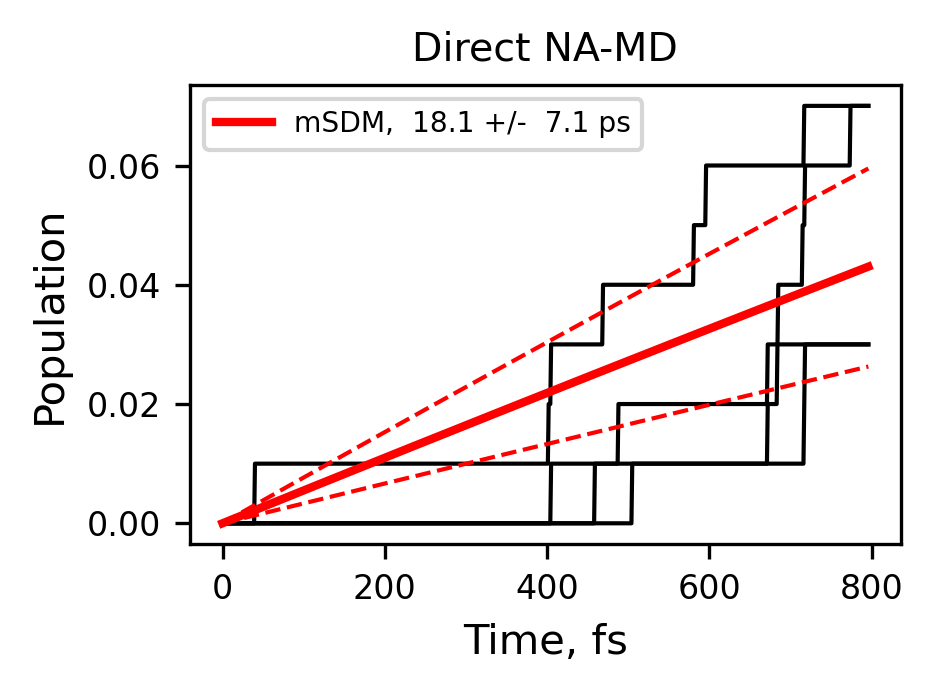

    *** Running decoherence method 21 ( mSDM2 ) *** 
raw data lengths: 797 797
Fitting parameters : A =  1.0  and B =  4.009385446576062e-05  1/B =  24941.478272037442
raw data lengths: 797 797
Fitting parameters : A =  1.0  and B =  6.623501634370989e-05  1/B =  15097.754257517692
raw data lengths: 797 797
Fitting parameters : A =  1.0  and B =  6.496877549763888e-05  1/B =  15392.009351266632
raw data lengths: 797 797
Fitting parameters : A =  1.0  and B =  5.713378383544757e-05  1/B =  17502.779141674302
Number of samples = 4
Lifetime from averaging individual lifetimes 18233.505255624015 +/- 4506.504752760289
Average rates  5.710785753563924e-05 +/- 1.1795010539640261e-05
Lifetime 17510.725198821037 +/- 3616.650968703277


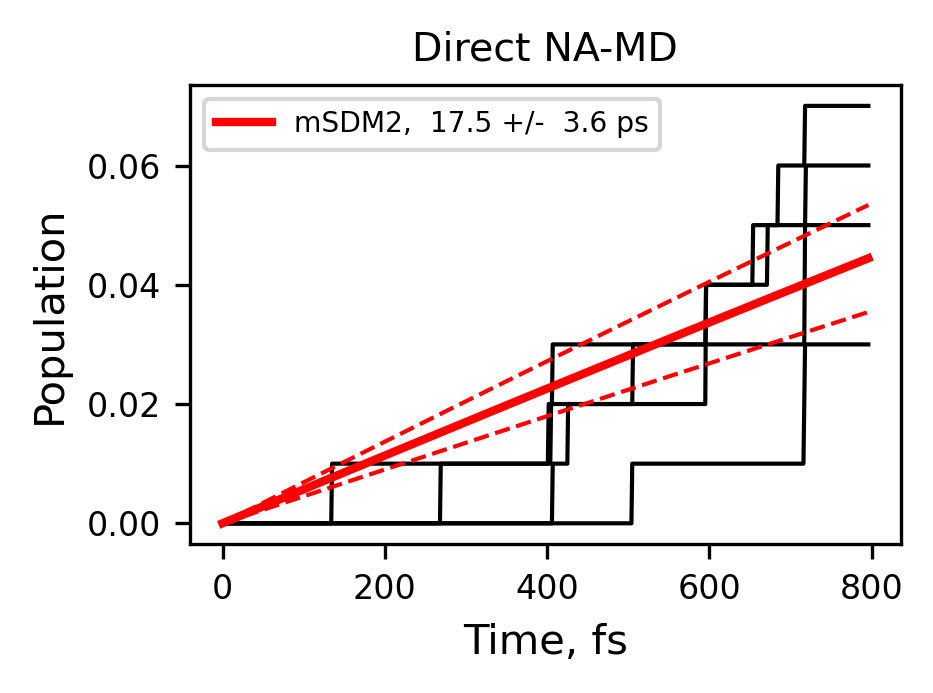

In [22]:
run_dynamics("direct", 2)

## 5. Decoherence times <a name="deco_times"></a>
[Back to TOC](#toc)

We have computed the average decoherence times between pairs of states when we ran the dynamics in the last cell in `average_decoherence.txt` file. Now, we load and plot it using `plt.imshow`.

Text(0, 0.5, 'State index')

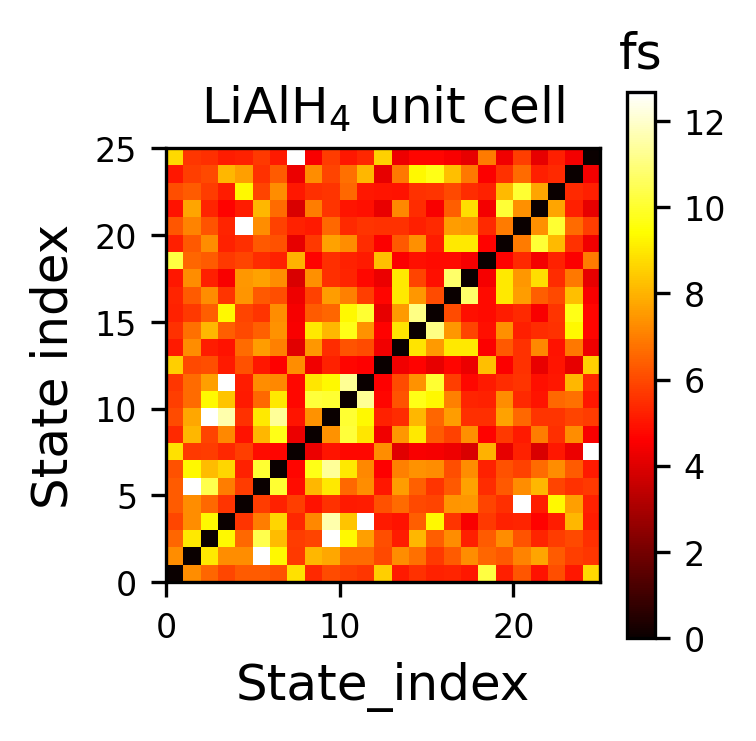

In [23]:
%matplotlib inline
#notebook
figure = plt.figure(num=None, figsize=(2.41, 2.41), dpi=300, edgecolor='black', frameon=True)        

avg_deco = np.loadtxt('average_decoherence_mSDM.txt')
plt.imshow(np.flipud(avg_deco), extent=(0,avg_deco.shape[0],0,avg_deco.shape[1]), cmap='hot')
plt.colorbar().ax.set_title('fs')
plt.title('LiAlH$_4$ unit cell')
plt.xlabel('State_index')
plt.ylabel('State index')

## 6. Fitting data <a name="fit_data"></a>
[Back to TOC](#toc)


After the dynamic is done, we load all the NA-MD results, stored in `SH_pop.txt` files, using `np.loadtxt` and start fitting them to a stretched-compressed exponential function of the form:

$$P(t; E_0)=\exp(-(\frac{t}{\tau})^\beta)$$


Then, the average time scale is computed for the fits that has an $R^2$ value more than $0.01$. The error bars are computed using the following formula:

$$\epsilon=Z\frac{s}{\sqrt{N}}$$

where $s$ is the stadard deviaton and $N$ is the number of samples (the ones that have $R^2$ value of more than $0.01$). The $Z$ value is the confidence interval coefficient which for confidence interval of $95\%$, a value of $1.96$ is chosen.

In the above, we have only considered, FSSH and IDA ad for simplicity, we will consider the decay dynamics of the hot state which is the 10th state. Also, please note that this is just an example and we want to show how the workflow is. So, we consider even lower $R^2$ value. For better and more accurate results, we need not only longer trajectory but also larger number of surface hopping trajectory.

------------mSDM----------
Folder = ./namd_regular/_start_s10_mSDM_batch0
tau: 372.12374122003916  beta: 0.8123589483796969  R2: 0.9965148197809676
Folder = ./namd_regular/_start_s10_mSDM_batch1
tau: 424.77122453060207  beta: 0.925545060333187  R2: 0.9900626694494397
Folder = ./namd_regular/_start_s10_mSDM_batch2
tau: 443.85930449473557  beta: 0.9125603654507279  R2: 0.9931855279311579
Folder = ./namd_regular/_start_s10_mSDM_batch3
tau: 446.3630787921391  beta: 1.1073076027233388  R2: 0.9976238362380145
The timescales: 421.77933725937896+-29.262949774244923 average over 4 samples
------------mSDM2----------
Folder = ./namd_regular/_start_s10_mSDM2_batch0
tau: 424.77122453060207  beta: 0.925545060333187  R2: 0.9900626694494397
Folder = ./namd_regular/_start_s10_mSDM2_batch1
tau: 423.8917699728843  beta: 0.9249207065654937  R2: 0.9952940790583673
Folder = ./namd_regular/_start_s10_mSDM2_batch2
tau: 465.95739477228216  beta: 0.9062546068587841  R2: 0.9975052080663467
Folder = ./namd_regul

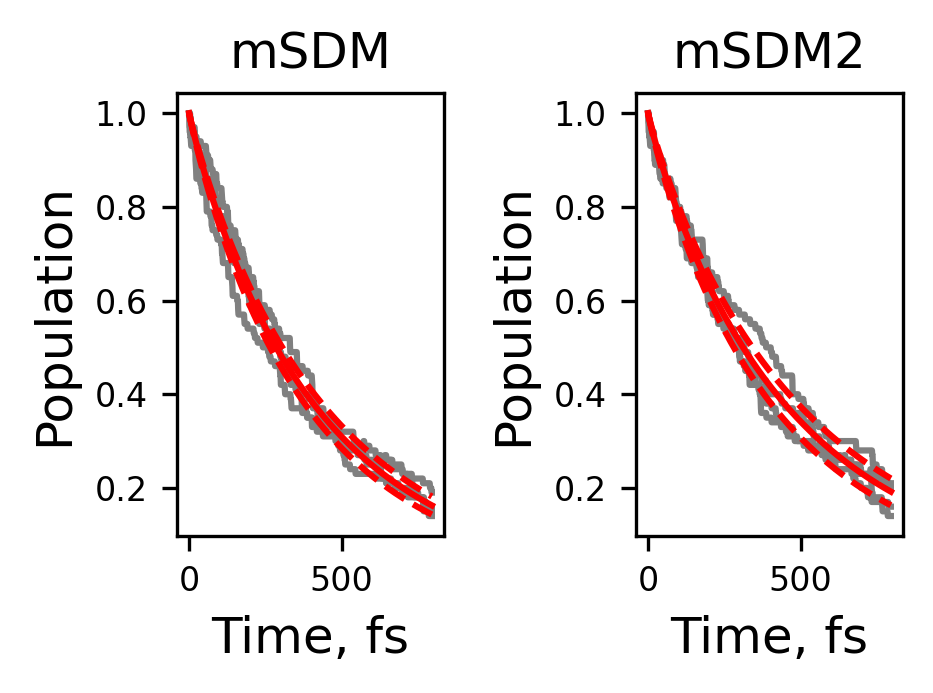

In [24]:
%matplotlib inline
#notebook
figure = plt.figure(num=None, figsize=(3.21, 2.41), dpi=300, edgecolor='black', frameon=True)        

def stretched_compressed(t, tau, beta):
    return np.exp( -np.power(( t/tau ),beta) )


for c, scheme in enumerate(['mSDM','mSDM2']):
    
    print(F'------------{scheme}----------')
    plt.subplot(1,2,c+1)
    folders = glob.glob(F'./namd_regular/_start_s10_{scheme}_batch*', recursive = True)
    taus = []
    betas = []
    
    for folder in folders:
        
        print("Folder =", folder)
        sh_pop = np.loadtxt(folder+'/SH_pop.txt')
        sh_pop_hot_state = sh_pop[:,10]
        md_time = np.arange(0, sh_pop_hot_state.shape[0], 1.0)
        popt, pcov = curve_fit( stretched_compressed, md_time, sh_pop_hot_state, 
                                   bounds=([0.0, 0.0],[np.inf, np.inf]))
        tau, beta = popt
        # Computing the R-squared
        residuals  = sh_pop_hot_state - stretched_compressed(md_time, *popt)
        ss_res     = np.sum(residuals**2)
        ss_tot     = np.sum((sh_pop_hot_state - np.mean(sh_pop_hot_state))**2)
        r_squared  = 1.0 - (ss_res / ss_tot)
        print('tau:', tau, ' beta:', beta,' R2:', r_squared)
        
        if r_squared>0.01:
            taus.append(tau)
            betas.append(beta)
            plt.plot(md_time, sh_pop_hot_state, color='gray')
            
    ave_tau = np.average(np.array(taus))
    ave_beta = np.average(np.array(betas))
    # Compute the erro bars
    # The confidence interval
    Z = 1.96
    N = len(taus)
    s = np.std(np.array(taus))
    error_bar = Z*s/np.sqrt(N)
    print(F'The timescales: {ave_tau}+-{error_bar} average over {len(taus)} samples')
    
    # Plot average fit
    
    plt.plot(md_time, stretched_compressed(md_time, ave_tau-error_bar, ave_beta), ls='--', color='red')
    plt.plot(md_time, stretched_compressed(md_time, ave_tau,           ave_beta), ls='-',  color='red')
    plt.plot(md_time, stretched_compressed(md_time, ave_tau+error_bar, ave_beta), ls='--', color='red')
    
    plt.title(scheme)
    plt.xlabel('Time, fs')
    plt.ylabel('Population')
    plt.tight_layout()

        
        